Original Aggregated DataFrame Columns:
['date', 'Shapefile', 'NDCI', 'FAI', 'Turbidity', 'NDTI', 'SABI']

Original Stations DataFrame Columns:
['date', 'Station ID', 'Collection_Date', 'Measure Date', 'Test Name', 'Test Number', 'Value', 'Units', 'LAT', 'LONG', 'index_right', 'ShapefileName']

Pivoted Stations DataFrame Head:
Test Name     Collection_Date ShapefileName  CHLOROPHYLL-A(LC)  \
0         2020-01-02 08:02:00         S308C                NaN   
1         2020-01-02 08:03:00         S308C                NaN   
2         2020-01-06 09:10:00      LakeO_NW                NaN   
3         2020-01-06 09:25:00      LakeO_NW               30.0   
4         2020-01-06 09:32:00      LakeO_NW               21.1   

Test Name  CHLOROPHYLL-B (LC)  DISSOLVED OXYGEN  MICROCYSTIN HILR  \
0                         NaN              4.78               NaN   
1                         NaN               NaN               NaN   
2                         NaN              8.91               NaN   

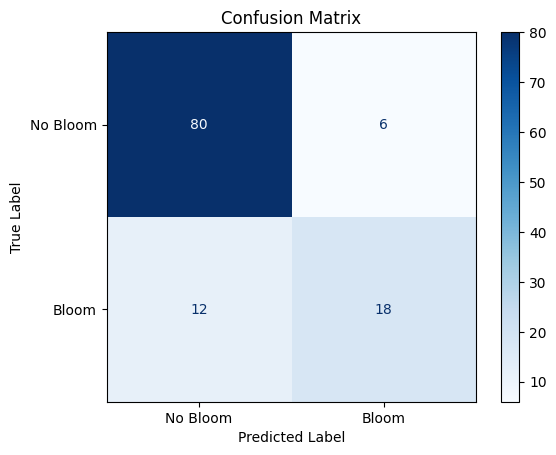


ROC AUC: 0.8946


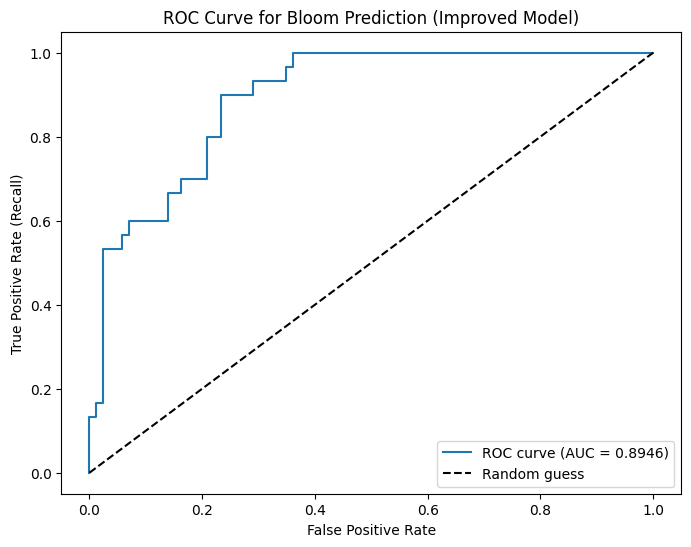


Feature Importances:
TOTAL NITROGEN           0.220309
PH, FIELD                0.169237
TURBIDITY_station        0.162721
Temperature              0.131248
DISSOLVED OXYGEN         0.073900
PHOSPHATE, TOTAL AS P    0.055115
NDCI                     0.051650
Turbidity_satellite      0.049972
FAI                      0.038269
NDTI                     0.025275
SABI                     0.022304
dtype: float64


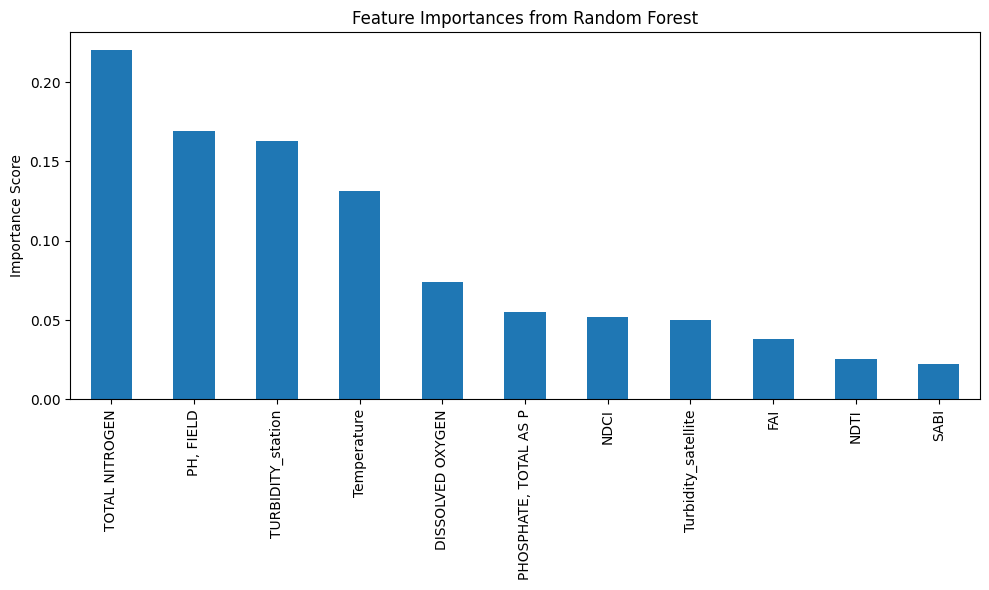


Analysis Complete.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# --- 1. Load Data ---
# Adjust file paths as necessary
'''
try:
    # Assuming the CSVs are in the same directory as the notebook or provide full paths
    aggregated_df = pd.read_csv("HABProject/Aggregated_Shapefiles_Data_Cleaned.csv")
    stations_df = pd.read_csv("HABProject/Stations_with_Shapefile_Names_dateindexed.csv")
    print("Files loaded successfully.")
except FileNotFoundError:
    print("Error: One or both CSV files not found. Please check file paths.")
    # You might want to exit or handle this error appropriately
    exit() # Example: exit if files aren't found
'''

aggregated_df = pd.read_csv("Aggregated_Shapefiles_Data_Cleaned.csv")
stations_df = pd.read_csv("Stations_with_Shapefile_Names_dateindexed.csv")

print("Original Aggregated DataFrame Columns:")
print(aggregated_df.columns.tolist()) # [cite: 1]
print("\nOriginal Stations DataFrame Columns:")
print(stations_df.columns.tolist()) # [cite: 1]


# --- 2. Preprocessing ---

# Convert date columns to datetime objects and keep only the date part
aggregated_df['date'] = pd.to_datetime(aggregated_df['date']).dt.date # [cite: 13]
stations_df['Collection_Date'] = pd.to_datetime(stations_df['Collection_Date']) # Keep time for potential pivoting issues if times differ slightly

# Pivot the stations data to get measurements as columns
# Using mean aggregation as in the original notebook [cite: 2]
# Handling potential duplicate entries for the same station/test on the same day
stations_pivoted = stations_df.pivot_table(
    index=["Collection_Date", "ShapefileName"], # Use original column names before rename
    columns="Test Name",
    values="Value",
    aggfunc='mean'
).reset_index()
print("\nPivoted Stations DataFrame Head:")
print(stations_pivoted.head())

# Rename columns for merging [cite: 4]
stations_pivoted.rename(columns={
    "Collection_Date": "datetime", # Keep datetime temporarily for matching if needed, then convert
    "ShapefileName": "Shapefile"
}, inplace=True)

# Convert the pivoted date column to just date for merging
stations_pivoted['date'] = stations_pivoted['datetime'].dt.date

# Merge the aggregated satellite data with the pivoted station data [cite: 13]
# Use 'inner' merge to keep only rows where both satellite and station data exist for the date/shapefile
merged_df = pd.merge(
    aggregated_df,
    stations_pivoted.drop(columns=['datetime']), # Drop the temporary datetime column
    how="inner",
    on=["date", "Shapefile"]
)
print("\nMerged DataFrame Head:")
print(merged_df.head())
print(f"\nMerged DataFrame shape: {merged_df.shape}")

# --- 3. Feature Selection and Target Definition ---

# Define potential features: Satellite indices + key station measurements
# Select columns that are likely relevant and handle potential variations in names
potential_features = [
    'NDCI', 'FAI', 'Turbidity_satellite', 'NDTI', 'SABI', # Satellite data (renaming 'Turbidity' to avoid clash)
    'TOTAL NITROGEN', 'PHOSPHATE, TOTAL AS P', 'Temperature', 'PH, FIELD',
    'DISSOLVED OXYGEN', 'TURBIDITY_station' # Station data (renaming 'TURBIDITY')
]

# Rename columns in merged_df to avoid clashes before selecting
merged_df.rename(columns={'Turbidity': 'Turbidity_satellite', 'TURBIDITY': 'TURBIDITY_station'}, inplace=True)

# Filter features that actually exist in the merged dataframe
feature_cols = [col for col in potential_features if col in merged_df.columns]
print(f"\nSelected features for modeling: {feature_cols}")

# Define the target variable 'bloom' based on Chlorophyll-A levels [cite: 23]
target_col = 'CHLOROPHYLL-A(LC)'
bloom_threshold = 30 # µg/L (using the example threshold [cite: 23])

# Drop rows where the target variable itself is missing before defining 'bloom'
merged_df.dropna(subset=[target_col], inplace=True)
print(f"\nDataFrame shape after dropping rows with missing '{target_col}': {merged_df.shape}")

merged_df['bloom'] = (merged_df[target_col] >= bloom_threshold).astype(int)

# Check distribution of the target variable
print("\nBloom distribution:")
print(merged_df['bloom'].value_counts())

# Select final features (X) and target (y)
X = merged_df[feature_cols]
y = merged_df['bloom']

# --- 4. Train-Test Split ---
# Split data *before* imputation to prevent data leakage [cite: 42]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, # Using 25% test size for a slightly larger test set
    random_state=42,
    stratify=y # Stratify to maintain bloom proportion in train/test sets
)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# --- 5. Preprocessing Pipeline and Model Training ---

# Create a pipeline: Impute missing values (median) -> Train RandomForest
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Use median imputation
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced')) # Added balanced class weight
])

# Define a parameter grid for RandomizedSearchCV
# Reduced grid for faster example execution, expand as needed
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

# Use RandomizedSearchCV to find good hyperparameters
# n_iter controls how many parameter combinations are tried
# cv is the number of cross-validation folds
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20, # Number of parameter settings that are sampled. Increase for better search.
    cv=5,       # 5-fold cross-validation
    scoring='accuracy', # Or 'roc_auc', 'f1', etc. depending on priority
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,
    verbose=1 # Set to 1 or higher to see progress
)

print("\nStarting Hyperparameter Search...")
random_search.fit(X_train, y_train)

print(f"\nBest Parameters found: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_:.4f}")

# Use the best estimator found by the search
best_model = random_search.best_estimator_

# --- 6. Evaluation ---

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1] # Probabilities for ROC curve

# Calculate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {acc:.4f}")

# Print classification report [cite: 42]
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


#Customizing confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
# Specify your custom labels
custom_labels = ["No Bloom", "Bloom"]

# Create the ConfusionMatrixDisplay object with your custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=custom_labels)
# Plot the confusion matrix with a custom colormap; here we use 'Blues'
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig('ConfusionMatrix_40mg.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

# Plot ROC Curve [cite: 50]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve for Bloom Prediction (Improved Model)")
plt.legend(loc="lower right")
plt.savefig('ROC_curve_40mg.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

# --- 7. Feature Importance ---

# Extract feature importances from the RandomForest model within the pipeline
# Access the classifier step and its feature_importances_ attribute
importances = best_model.named_steps['classifier'].feature_importances_
feature_names = X_train.columns # Get column names from the training data fed into pipeline

# Create a pandas series for easier viewing
feature_importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("\nFeature Importances:")
print(feature_importance_series)

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importance_series.plot(kind='bar')
plt.title("Feature Importances from Random Forest")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.savefig('FeatureImportance_40mg.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAnalysis Complete.")

In [3]:
# Save the merged DataFrame to a CSV file
merged_df.to_csv("Merged_Data_Final.csv", index=False)

# Running Statistical Tests

### Boxplot of peak vs non-peak season for chlorophyll-a concentrations

Mean Chlorophyll-a during Peak Bloom Season: 31.08 µg/L
Mean Chlorophyll-a during Rest of the Year: 17.64 µg/L

T-Test between Peak Bloom Season and Rest of Year: T-statistic = 4.2862, P-value = 0.0000


C:\Users\Socce\AppData\Local\Temp\ipykernel_3024\5684180.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([bloom_data, rest_data], labels=['Peak Bloom Season', 'Rest of the Year'])


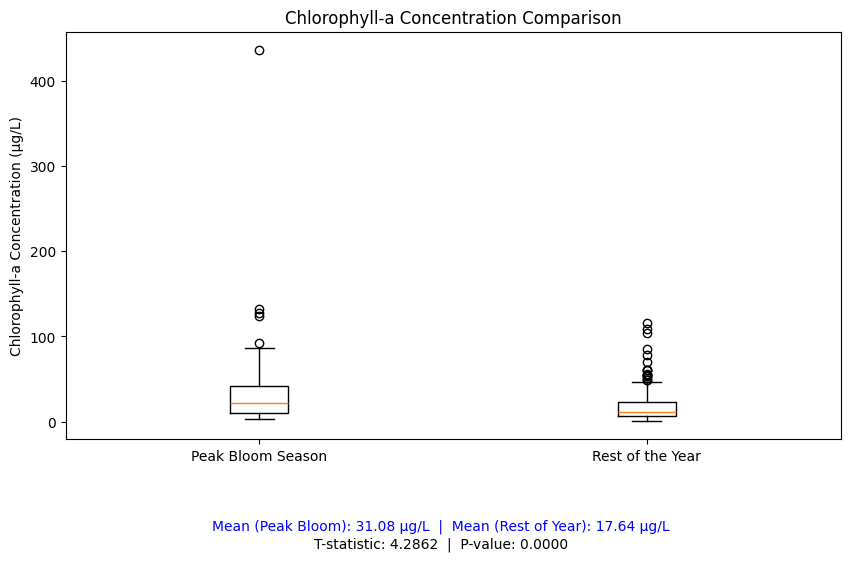

In [44]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame and contains 'CHLOROPHYLL-A(LC)' and 'date'

# 1. Convert the date column to datetime if it's not already done
merged_df['date'] = pd.to_datetime(merged_df['date'])

# 2. Create a new column for Peak Bloom Season
merged_df['bloom_season'] = merged_df['date'].apply(lambda x: 'Peak Bloom Season' if x.month in [6, 7, 8, 9] else 'Rest of the Year')

# 3. Calculate mean chlorophyll-a for both periods
mean_bloom = merged_df[merged_df['bloom_season'] == 'Peak Bloom Season']['CHLOROPHYLL-A(LC)'].mean()
mean_rest = merged_df[merged_df['bloom_season'] == 'Rest of the Year']['CHLOROPHYLL-A(LC)'].mean()

print(f"Mean Chlorophyll-a during Peak Bloom Season: {mean_bloom:.2f} µg/L")
print(f"Mean Chlorophyll-a during Rest of the Year: {mean_rest:.2f} µg/L")

# 4. Perform a t-test between the two groups
bloom_data = merged_df[merged_df['bloom_season'] == 'Peak Bloom Season']['CHLOROPHYLL-A(LC)']
rest_data = merged_df[merged_df['bloom_season'] == 'Rest of the Year']['CHLOROPHYLL-A(LC)']

# Perform the t-test
t_stat, p_value = stats.ttest_ind(bloom_data, rest_data, equal_var=False)
print(f"\nT-Test between Peak Bloom Season and Rest of Year: T-statistic = {t_stat:.4f}, P-value = {p_value:.4f}")

# 5. Visualize the comparison
plt.figure(figsize=(10, 6))
plt.boxplot([bloom_data, rest_data], labels=['Peak Bloom Season', 'Rest of the Year'])
plt.title('Chlorophyll-a Concentration Comparison')
plt.ylabel('Chlorophyll-a Concentration (µg/L)')

# Adjust layout to provide space for annotations below
plt.subplots_adjust(bottom=0.2)

# Add annotations for mean chlorophyll-a levels below the plot
mean_text = f'Mean (Peak Bloom): {mean_bloom:.2f} µg/L  |  Mean (Rest of Year): {mean_rest:.2f} µg/L'
plt.figtext(0.5, 0.05, mean_text, ha='center', fontsize=10, color='blue')

# T-statistic and P-value positioned below the figure
stat_text = f'T-statistic: {t_stat:.4f}  |  P-value: {p_value:.4f}'
plt.figtext(0.5, 0.02, stat_text, ha='center', fontsize=10, color='black')

# Save the figure as a PNG file
plt.savefig("Chlorophyll_Comparison.png", dpi=300)  # Specify dpi for quality (300 is high quality)

# Show the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

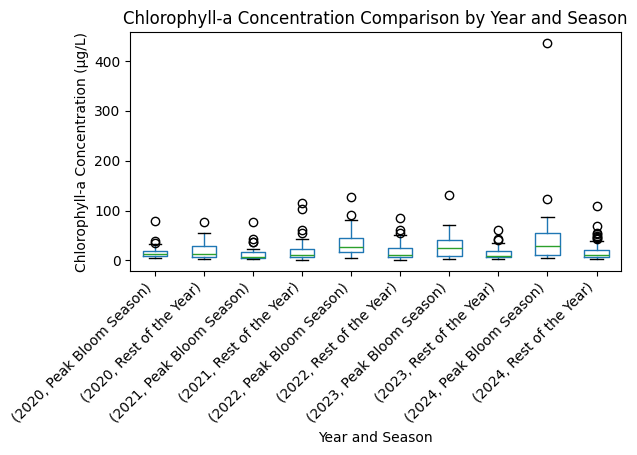

In [47]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame and contains 'CHLOROPHYLL-A(LC)' and 'date'

# 1. Convert the date column to datetime if it's not already done
merged_df['date'] = pd.to_datetime(merged_df['date'])

# 2. Create a new column for year
merged_df['year'] = merged_df['date'].dt.year

# 3. Create a new column for Peak Bloom Season
merged_df['bloom_season'] = merged_df['date'].apply(lambda x: 'Peak Bloom Season' if x.month in [6, 7, 8, 9] else 'Rest of the Year')

# 4. Visualize the comparison by Year and Season
plt.figure(figsize=(12, 6))

# Create boxplot with multi-level grouping by year and season
boxplot = merged_df.boxplot(column='CHLOROPHYLL-A(LC)', by=['year', 'bloom_season'], grid=False)

# Adding Titles and Labels
plt.title('Chlorophyll-a Concentration Comparison by Year and Season')
plt.suptitle('')  # Suppress the default title to keep it clean
plt.xlabel('Year and Season')
plt.ylabel('Chlorophyll-a Concentration (µg/L)')

# Improve x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Adjust layout to prevent clipping
plt.tight_layout()  # This adjusts the layout to ensure everything fits

# Save the figure as a PNG file with tight bounding box
plt.savefig("Chlorophyll_Comparison_Yearly.png", dpi=300, bbox_inches='tight')  # Specify dpi for quality (300 is high quality)

# Show the plot
plt.show()

### Histogram of bloom vs no bloom counts of chlorophyll-a at 40 threshold

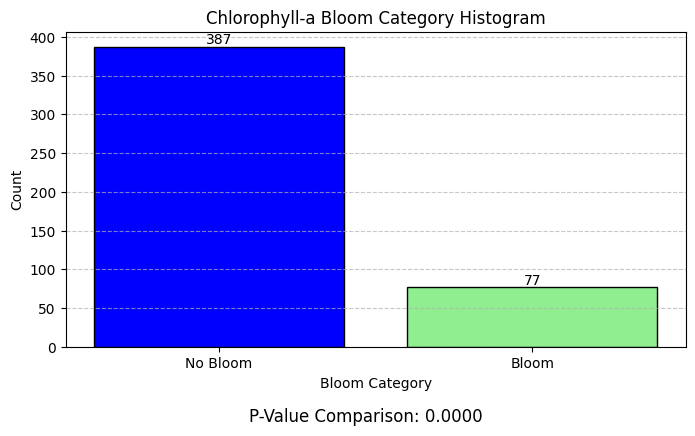

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Assuming merged_df is your DataFrame and contains 'CHLOROPHYLL-A(LC)'

# 1. Create a new column for Bloom category
merged_df['Bloom Category'] = merged_df['CHLOROPHYLL-A(LC)'].apply(lambda x: 'Bloom' if x >= 40 else 'No Bloom')

# 2. Separate data into Bloom and No Bloom groups
bloom_data = merged_df[merged_df['Bloom Category'] == 'Bloom']['CHLOROPHYLL-A(LC)']
no_bloom_data = merged_df[merged_df['Bloom Category'] == 'No Bloom']['CHLOROPHYLL-A(LC)']

# 3. Perform t-test between the two groups
t_stat, p_value = stats.ttest_ind(bloom_data, no_bloom_data, equal_var=False)

# 4. Count the occurrences of each category
count_bloom = merged_df['Bloom Category'].value_counts()

# 5. Plot the histogram
plt.figure(figsize=(8, 5))
plt.bar(count_bloom.index, count_bloom.values, color=['blue', 'lightgreen'], edgecolor='black')
plt.title('Chlorophyll-a Bloom Category Histogram')
plt.xlabel('Bloom Category')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x labels if necessary for visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the value counts on top of the bars
for idx, value in enumerate(count_bloom.values):
    plt.text(idx, value, str(value), ha='center', va='bottom')

# Adjust layout to provide more space for annotations below
plt.subplots_adjust(bottom=0.25)  # Increased bottom space

# Add p-value annotation below the plot
p_value_text = f'P-Value Comparison: {p_value:.4f}'
plt.figtext(0.5, 0.1, p_value_text, ha='center', fontsize=12, color='black')

# Save the figure as a PNG file
plt.savefig("Chlorophyll_Bloom_Category_Histogram_with_Pvalue.png", dpi=300)

# Show the plot
plt.show()

### Bloom days vs. non-bloom days both inside and out of peak bloom season

['date', 'Shapefile', 'NDCI', 'FAI', 'Turbidity_satellite', 'NDTI', 'SABI', 'CHLOROPHYLL-A(LC)', 'CHLOROPHYLL-B (LC)', 'DISSOLVED OXYGEN', 'MICROCYSTIN HILR', 'MICROCYSTIN HTYR', 'MICROCYSTIN LA', 'MICROCYSTIN LF', 'MICROCYSTIN LR', 'MICROCYSTIN LW', 'MICROCYSTIN LY', 'MICROCYSTIN RR', 'MICROCYSTIN WR', 'MICROCYSTIN YR', 'MICROCYSTIN-LR (EQUIV)', 'NITRATE+NITRITE-N', 'NITRATE-N', 'NITRITE-N', 'NITROGEN, TOTAL DISSOLVED', 'PH, FIELD', 'PHOSPHATE, DISSOLVED AS P', 'PHOSPHATE, ORTHO AS P', 'PHOSPHATE, TOTAL AS P', 'SULFATE', 'TOTAL NITROGEN', 'TOTAL SUSPENDED SOLIDS', 'TURBIDITY_station', 'Temperature', 'VOLATILE SUSPENDED SOLIDS', 'bloom', 'bloom_season']


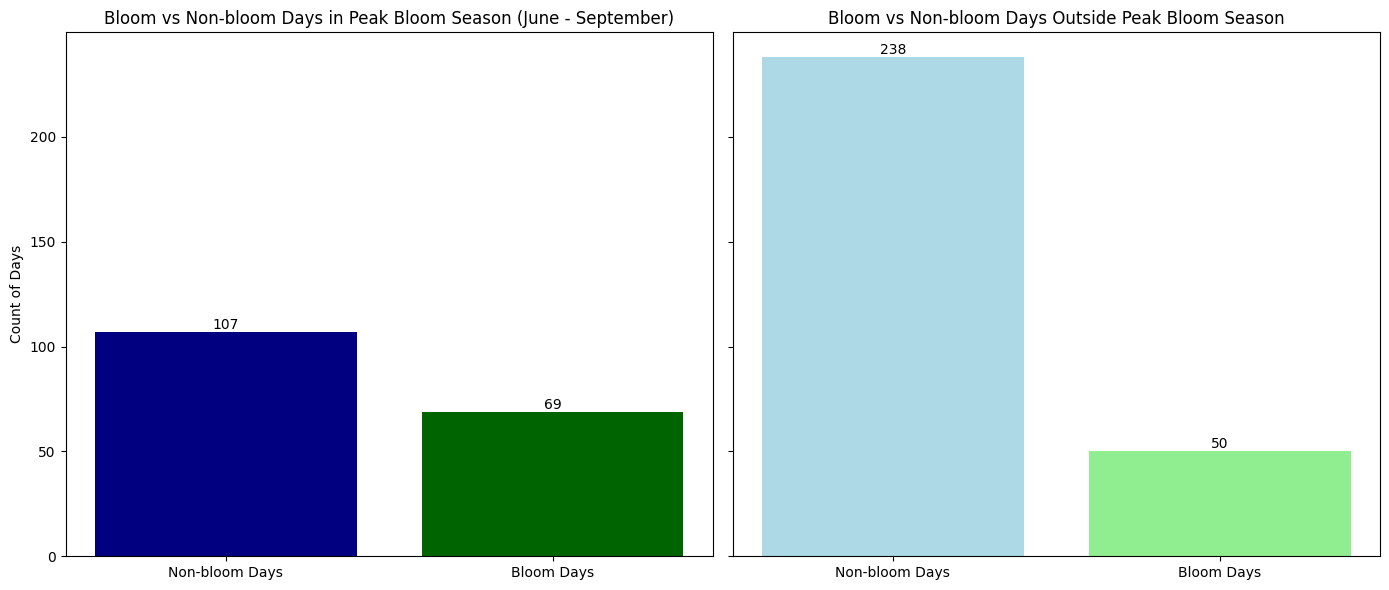

<Figure size 640x480 with 0 Axes>

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your data
merged_df = pd.read_csv('Merged_Data_Final.csv')

# Check the columns in the DataFrame
print(merged_df.columns.tolist())  # Inspect the column names

# Optional: Strip any leading or trailing spaces from column names
merged_df.columns = merged_df.columns.str.strip()

# Assuming you have identified correct column names
# Let's say 'DateColumn' is your date column, and 'bloom' is the column for bloom status
date_column_name = 'date'  # Replace with actual name
bloom_column_name = 'bloom'  # Adjust according to your data

# Ensure the date column is in datetime format
merged_df[date_column_name] = pd.to_datetime(merged_df[date_column_name])  

# Create 'is_bloom' column based on the bloom status (0 for non-bloom, 1 for bloom)
merged_df['is_bloom'] = merged_df[bloom_column_name] == 1  # Adjusted for 0/1 values

# Define peak bloom season
def is_peak_bloom(date):
    return 6 <= date.month <= 9

# Create a new column indicating peak bloom season
merged_df['peak_bloom_season'] = merged_df['date'].apply(is_peak_bloom)

# Count days in bloom vs non-bloom for peak and non-peak seasons
counts = merged_df.groupby(['peak_bloom_season', 'is_bloom']).size().unstack(fill_value=0)

# Ensure counts are shaped correctly
if counts.shape[0] < 2:  # Adjust if there aren't both true and false indices
    counts = counts.reindex([True, False], fill_value=0)

# Prepare data for plotting
labels = ['Non-bloom Days', 'Bloom Days']
peak_bloom_counts = counts.loc[True] if True in counts.index else [0, 0]  # Counts for peak bloom
non_peak_bloom_counts = counts.loc[False] if False in counts.index else [0, 0]  # Counts for non-peak bloom

# Plot the histograms
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Histogram for Peak Bloom Season
bars1 = axs[0].bar(labels, peak_bloom_counts, color=['navy', 'darkgreen'])
axs[0].set_title('Bloom vs Non-bloom Days in Peak Bloom Season (June - September)')
axs[0].set_ylabel('Count of Days')

# Add counts on top of the bars for Peak Bloom Season
for bar in bars1:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

# Histogram for Non-Peak Bloom Season
bars2 = axs[1].bar(labels, non_peak_bloom_counts, color=['lightblue', 'lightgreen'])
axs[1].set_title('Bloom vs Non-bloom Days Outside Peak Bloom Season')

# Add counts on top of the bars for Non-Peak Bloom Season
for bar in bars2:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

# Display the plot
plt.tight_layout()
plt.show()

['date', 'Shapefile', 'NDCI', 'FAI', 'Turbidity_satellite', 'NDTI', 'SABI', 'CHLOROPHYLL-A(LC)', 'CHLOROPHYLL-B (LC)', 'DISSOLVED OXYGEN', 'MICROCYSTIN HILR', 'MICROCYSTIN HTYR', 'MICROCYSTIN LA', 'MICROCYSTIN LF', 'MICROCYSTIN LR', 'MICROCYSTIN LW', 'MICROCYSTIN LY', 'MICROCYSTIN RR', 'MICROCYSTIN WR', 'MICROCYSTIN YR', 'MICROCYSTIN-LR (EQUIV)', 'NITRATE+NITRITE-N', 'NITRATE-N', 'NITRITE-N', 'NITROGEN, TOTAL DISSOLVED', 'PH, FIELD', 'PHOSPHATE, DISSOLVED AS P', 'PHOSPHATE, ORTHO AS P', 'PHOSPHATE, TOTAL AS P', 'SULFATE', 'TOTAL NITROGEN', 'TOTAL SUSPENDED SOLIDS', 'TURBIDITY_station', 'Temperature', 'VOLATILE SUSPENDED SOLIDS', 'bloom', 'bloom_season']


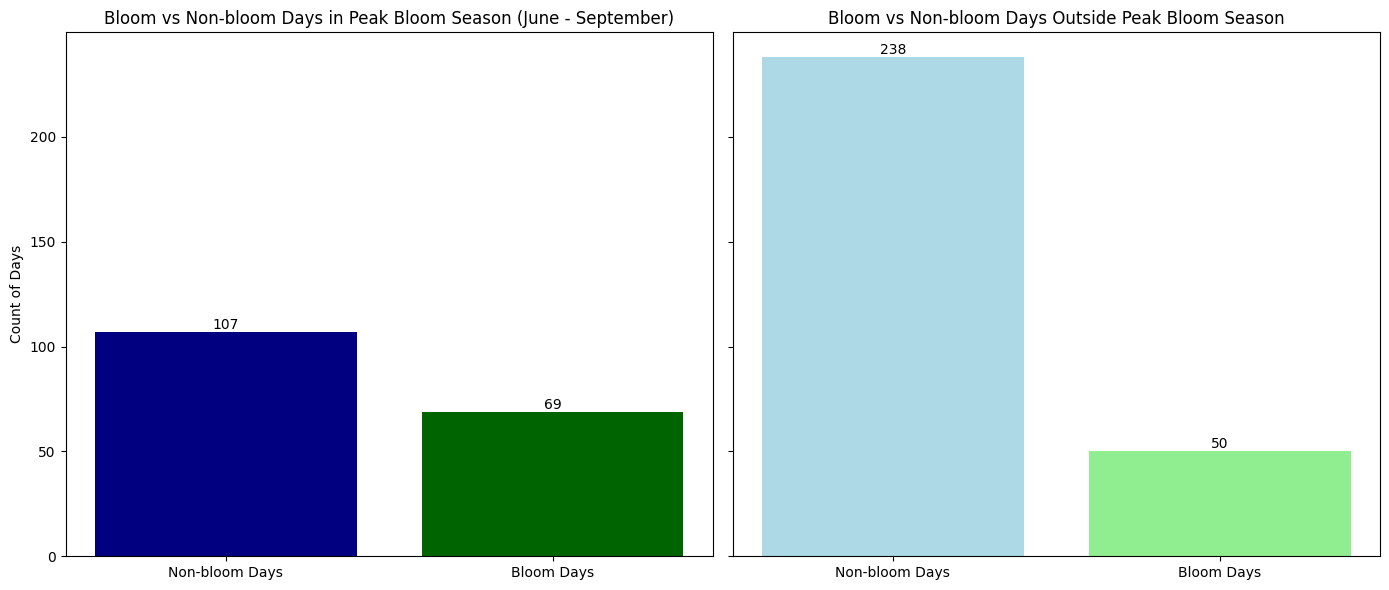

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your data
merged_df = pd.read_csv('Merged_Data_Final.csv')

# Check the columns in the DataFrame
print(merged_df.columns.tolist())  # Inspect the column names

# Optional: Strip any leading or trailing spaces from column names
merged_df.columns = merged_df.columns.str.strip()

# Assuming you have identified correct column names
# Let's say 'date' is your date column, and 'bloom' is the column for bloom status
date_column_name = 'date'  # Replace with actual name
bloom_column_name = 'bloom'  # Adjust according to your data

# Ensure the date column is in datetime format
merged_df[date_column_name] = pd.to_datetime(merged_df[date_column_name])  

# Create 'is_bloom' column based on the bloom status (0 for non-bloom, 1 for bloom)
merged_df['is_bloom'] = merged_df[bloom_column_name] == 1  # Adjusted for 0/1 values

# Define peak bloom season
def is_peak_bloom(date):
    return 6 <= date.month <= 9

# Create a new column indicating peak bloom season
merged_df['peak_bloom_season'] = merged_df[date_column_name].apply(is_peak_bloom)

# Count days in bloom vs non-bloom for peak and non-peak seasons
counts = merged_df.groupby(['peak_bloom_season', 'is_bloom']).size().unstack(fill_value=0)

# Ensure counts are shaped correctly
if counts.shape[0] < 2:  # Adjust if there aren't both true and false indices
    counts = counts.reindex([True, False], fill_value=0)

# Prepare data for plotting
labels = ['Non-bloom Days', 'Bloom Days']
peak_bloom_counts = counts.loc[True] if True in counts.index else [0, 0]  # Counts for peak bloom
non_peak_bloom_counts = counts.loc[False] if False in counts.index else [0, 0]  # Counts for non-peak bloom

# Plot the histograms
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Histogram for Peak Bloom Season
bars1 = axs[0].bar(labels, peak_bloom_counts, color=['navy', 'darkgreen'])
axs[0].set_title('Bloom vs Non-bloom Days in Peak Bloom Season (June - September)')
axs[0].set_ylabel('Count of Days')

# Add counts on top of the bars for Peak Bloom Season
for bar in bars1:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

# Histogram for Non-Peak Bloom Season
bars2 = axs[1].bar(labels, non_peak_bloom_counts, color=['lightblue', 'lightgreen'])
axs[1].set_title('Bloom vs Non-bloom Days Outside Peak Bloom Season')

# Add counts on top of the bars for Non-Peak Bloom Season
for bar in bars2:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

# Save the plot as a PNG file
plt.tight_layout()
plt.savefig('bloom_days_histogram.png', dpi=300)  # Save as PNG with 300 dpi
plt.show()

### Attempting to Generate Bloom Days and Non-Bloom Days inside and outside of peak season for each year

In [40]:
import pandas as pd

# Load your data from the original CSV file
# Replace 'your_data_file.csv' with the actual filename
year_df = pd.read_csv('Merged_Data_Final.csv')

# Assuming 'bloom' indicates bloom days with 1 and non-bloom days with 0
bloom_status_column_name = 'bloom'  # Adjust if necessary

# Create 'is_bloom' column based on the bloom status column
year_df['is_bloom'] = year_df[bloom_status_column_name] == 1  # True for bloom days, False for non-bloom days

# Export the updated DataFrame with 'is_bloom' to a new CSV file
year_df.to_csv('Merged_Data_Final_is_bloom.csv', index=False)

print("The new CSV file 'Merged_Data_Final_is_bloom.csv' has been created successfully.")

The new CSV file 'Merged_Data_Final_is_bloom.csv' has been created successfully.


Columns in the DataFrame: ['date', 'Shapefile', 'NDCI', 'FAI', 'Turbidity_satellite', 'NDTI', 'SABI', 'CHLOROPHYLL-A(LC)', 'CHLOROPHYLL-B (LC)', 'DISSOLVED OXYGEN', 'MICROCYSTIN HILR', 'MICROCYSTIN HTYR', 'MICROCYSTIN LA', 'MICROCYSTIN LF', 'MICROCYSTIN LR', 'MICROCYSTIN LW', 'MICROCYSTIN LY', 'MICROCYSTIN RR', 'MICROCYSTIN WR', 'MICROCYSTIN YR', 'MICROCYSTIN-LR (EQUIV)', 'NITRATE+NITRITE-N', 'NITRATE-N', 'NITRITE-N', 'NITROGEN, TOTAL DISSOLVED', 'PH, FIELD', 'PHOSPHATE, DISSOLVED AS P', 'PHOSPHATE, ORTHO AS P', 'PHOSPHATE, TOTAL AS P', 'SULFATE', 'TOTAL NITROGEN', 'TOTAL SUSPENDED SOLIDS', 'TURBIDITY_station', 'Temperature', 'VOLATILE SUSPENDED SOLIDS', 'bloom', 'bloom_season']
Year 2020 - Peak Bloom Counts: is_bloom
True      0
False    17
Name: count, dtype: int64, Non-Peak Count: is_bloom
True      0
False    43
Name: count, dtype: int64


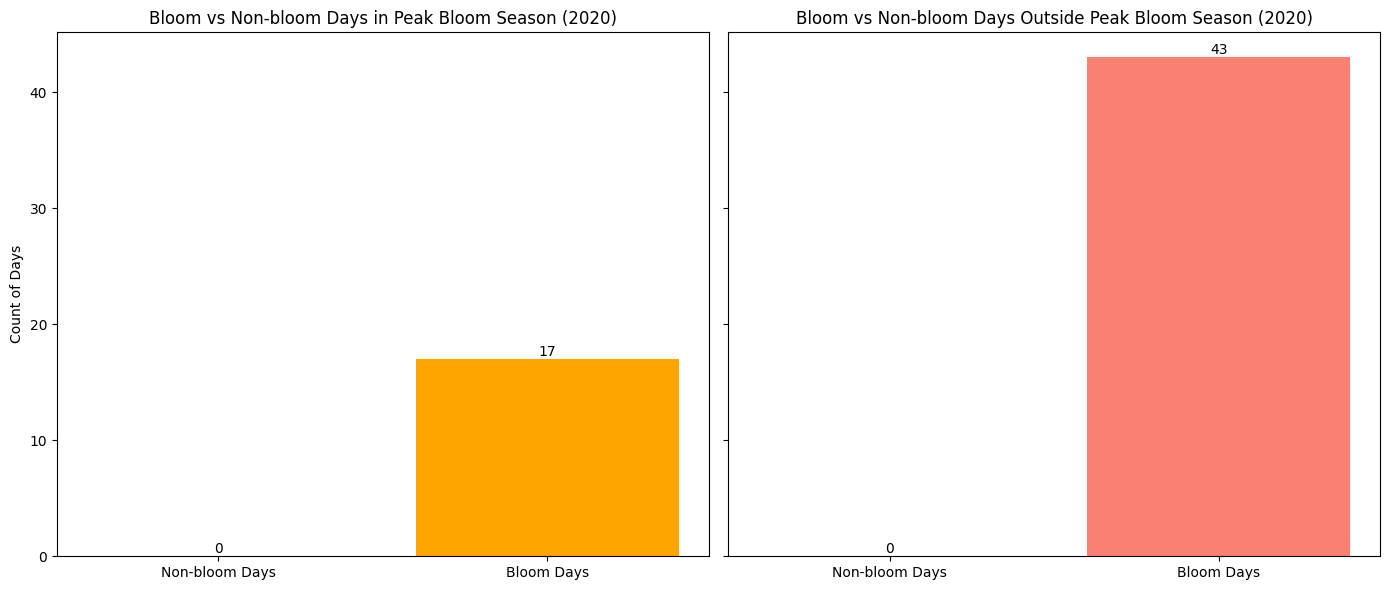

Year 2021 - Peak Bloom Counts: is_bloom
True      0
False    22
Name: count, dtype: int64, Non-Peak Count: is_bloom
True      0
False    62
Name: count, dtype: int64


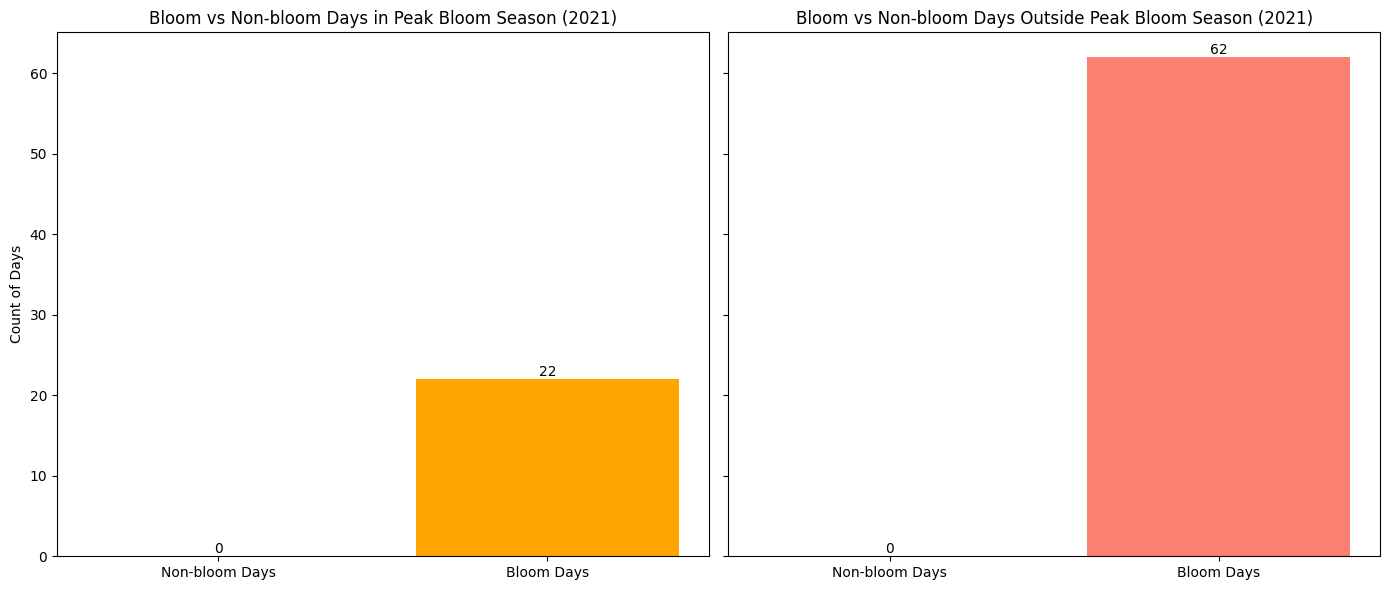

Year 2022 - Peak Bloom Counts: is_bloom
True      0
False    51
Name: count, dtype: int64, Non-Peak Count: is_bloom
True      0
False    67
Name: count, dtype: int64


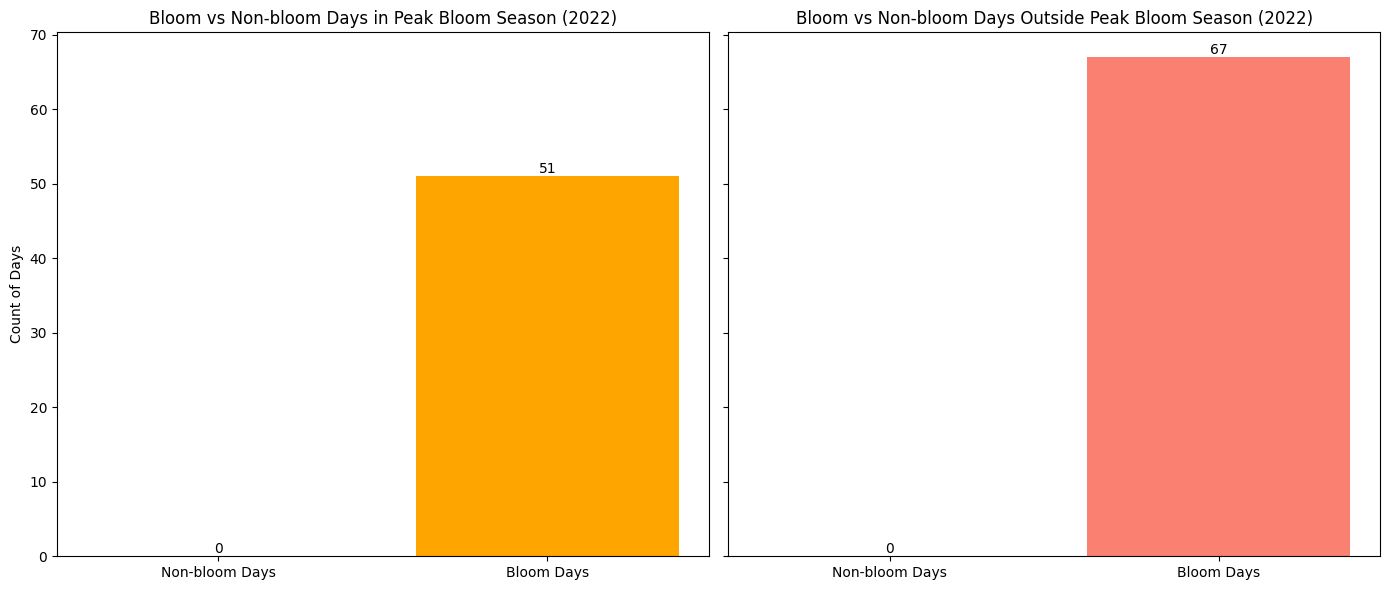

Year 2023 - Peak Bloom Counts: is_bloom
True      0
False    45
Name: count, dtype: int64, Non-Peak Count: is_bloom
True      0
False    50
Name: count, dtype: int64


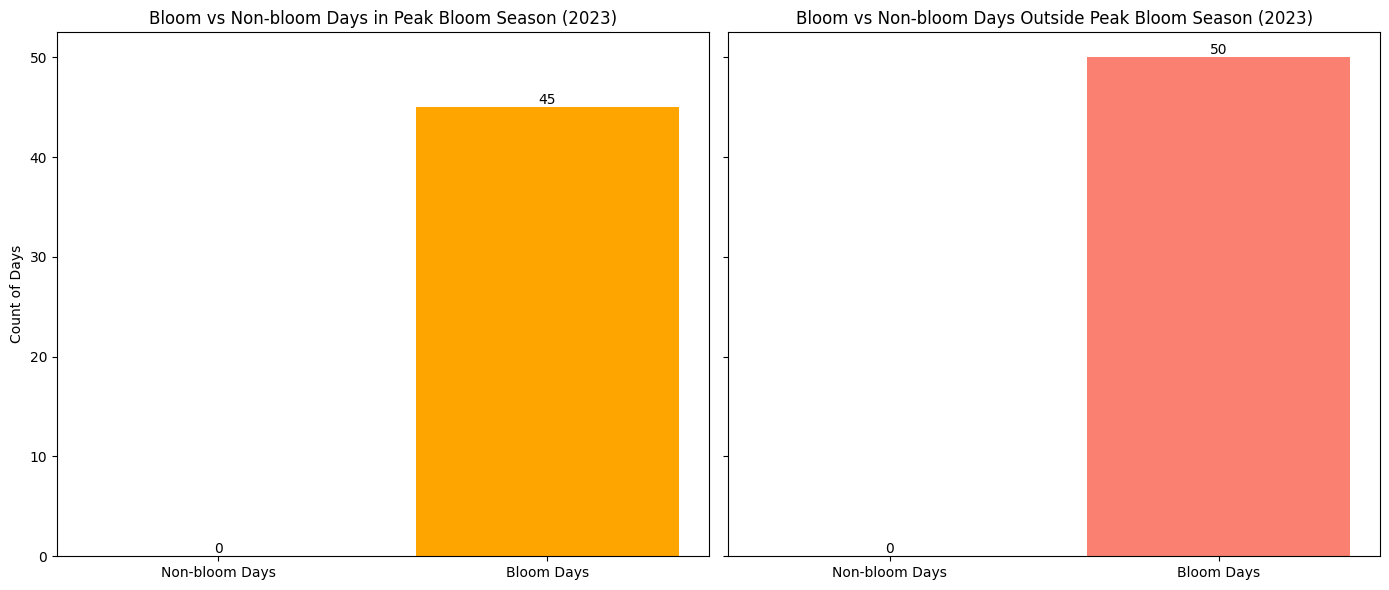

Year 2024 - Peak Bloom Counts: is_bloom
True      0
False    41
Name: count, dtype: int64, Non-Peak Count: is_bloom
True      0
False    66
Name: count, dtype: int64


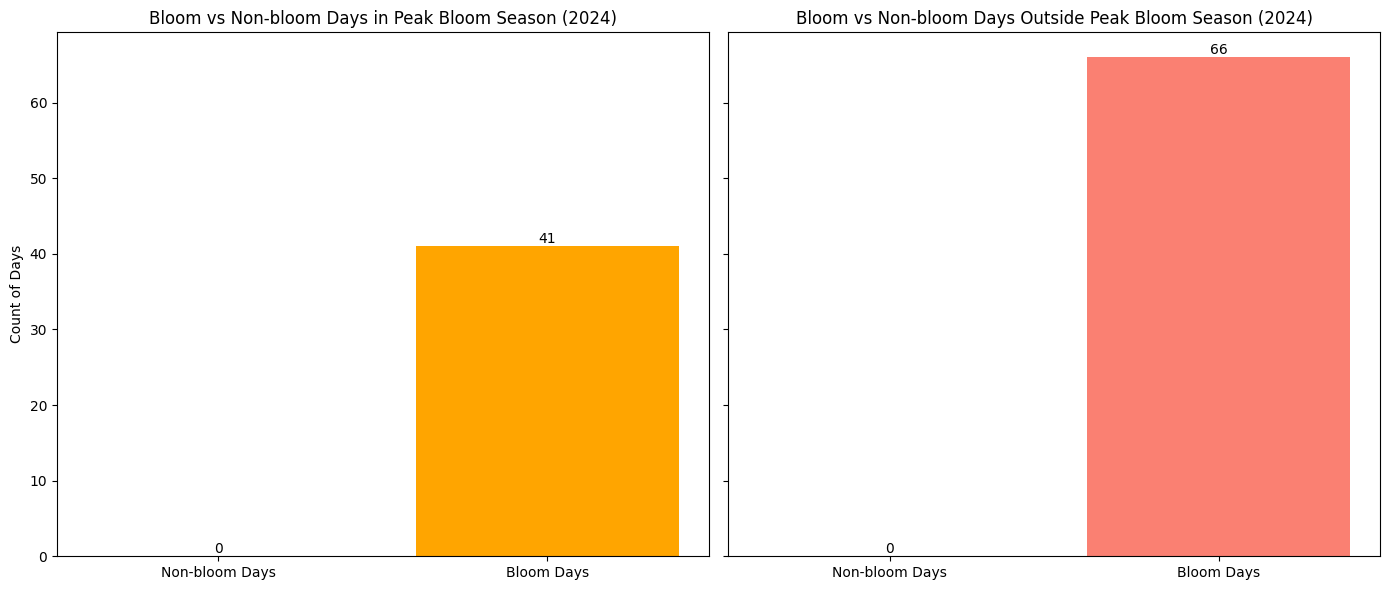

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your data
merged_df = pd.read_csv('Merged_Data_Final.csv')

# Check the columns in the DataFrame
print("Columns in the DataFrame:", merged_df.columns.tolist())

# Strip any leading or trailing spaces from column names
merged_df.columns = merged_df.columns.str.strip()

# Using 'date' for date information and assuming 'bloom' for bloom status
bloom_status_column_name = 'bloom'  # Adjust if needed

# Ensure the 'date' column is in datetime format
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')

# Check for any conversion issues
if merged_df['date'].isnull().any():
    print("There are invalid dates in the dataset.")

# Create 'is_bloom' column based on the bloom status column
merged_df['is_bloom'] = merged_df[bloom_status_column_name] == '1'  # Adjust if necessary

# Define peak bloom season
def is_peak_bloom(date):
    return 6 <= date.month <= 9

# Create a new column indicating peak bloom season
merged_df['peak_bloom_season'] = merged_df['date'].apply(is_peak_bloom)

# Extract the year from the date
merged_df['year'] = merged_df['date'].dt.year

# Get unique years from the data
years = merged_df['year'].unique()

# Create histograms for each year
for year in years:
    # Filter DataFrame for the specific year
    year_df = merged_df[merged_df['year'] == year]

    # Count days in bloom and non-bloom for both peak and non-peak seasons
    peak_counts = year_df[year_df['peak_bloom_season']]['is_bloom'].value_counts().reindex([True, False], fill_value=0)
    non_peak_counts = year_df[~year_df['peak_bloom_season']]['is_bloom'].value_counts().reindex([True, False], fill_value=0)

    # Debugging output to check counts
    print(f"Year {year} - Peak Bloom Counts: {peak_counts}, Non-Peak Count: {non_peak_counts}")

    # Prepare data for plotting
    labels = ['Non-bloom Days', 'Bloom Days']

    # Plot the histograms
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Histogram for Peak Bloom Season
    bars1 = axs[0].bar(labels, peak_counts, color=['skyblue', 'orange'])
    axs[0].set_title(f'Bloom vs Non-bloom Days in Peak Bloom Season ({year})')
    axs[0].set_ylabel('Count of Days')

    # Add counts on top of the bars for Peak Bloom Season
    for bar in bars1:
        yval = bar.get_height()
        axs[0].text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center')

    # Histogram for Non-Peak Bloom Season
    bars2 = axs[1].bar(labels, non_peak_counts, color=['lightgreen', 'salmon'])
    axs[1].set_title(f'Bloom vs Non-bloom Days Outside Peak Bloom Season ({year})')

    # Add counts on top of the bars for Non-Peak Bloom Season
    for bar in bars2:
        yval = bar.get_height()
        axs[1].text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center')

    # Display the plot for each year
    plt.tight_layout()
    plt.show()

### Shapefiles and Indices Time Series

         date Shapefile      NDCI         FAI  Turbidity_satellite      NDTI  \
0  2020-01-06  LakeO_NW  0.064189 -103.416242             3.300448 -0.094241   
1  2020-01-06  LakeO_NW  0.064189 -103.416242             3.300448 -0.094241   
2  2020-01-14  LakeO_NE  0.130501 -118.653926            51.431260 -0.208994   
3  2020-01-14  LakeO_NE  0.130501 -118.653926            51.431260 -0.208994   
4  2020-01-14  LakeO_NW  0.065300 -265.566231             4.539165 -0.053971   

       SABI  CHLOROPHYLL-A(LC)  CHLOROPHYLL-B (LC)  DISSOLVED OXYGEN  ...  \
0  0.278016              30.00                 NaN              9.85  ...   
1  0.278016              21.10                 NaN              9.84  ...   
2  0.677713               5.25                 NaN              8.65  ...   
3  0.677713               3.96                 NaN              8.91  ...   
4  0.384280              17.40                 NaN              8.08  ...   

   PHOSPHATE, ORTHO AS P  PHOSPHATE, TOTAL AS P  SULFATE

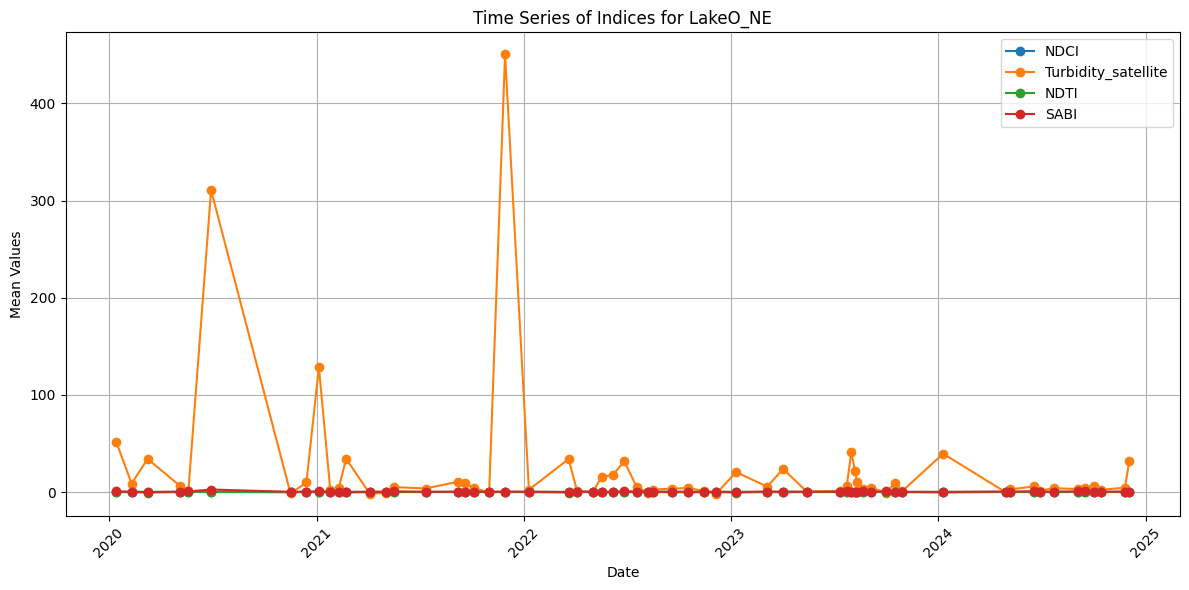

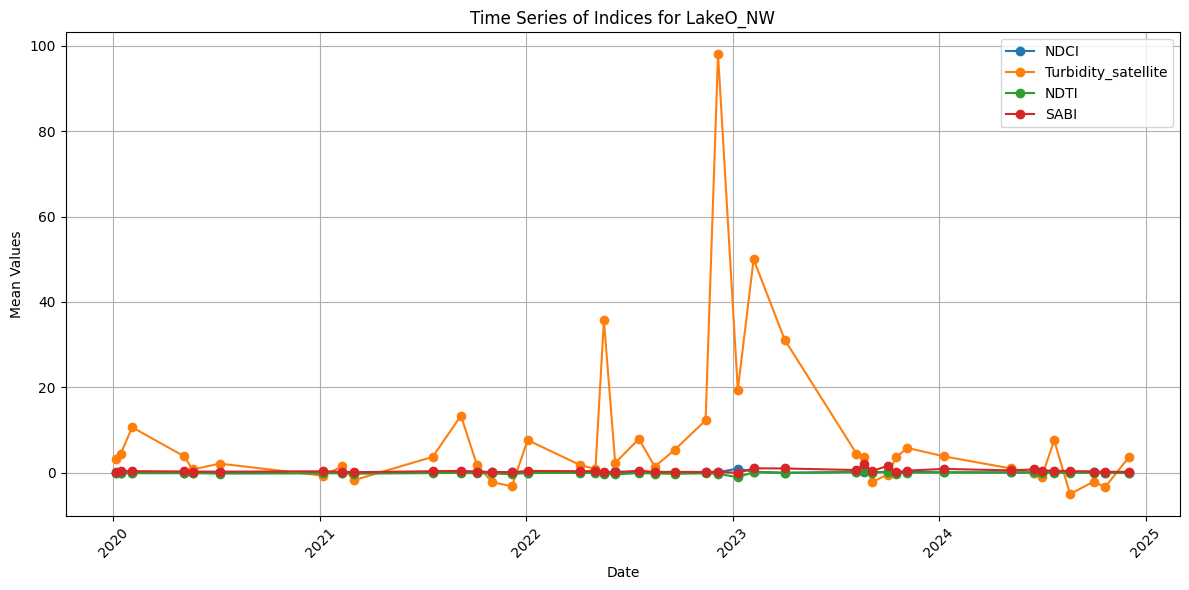

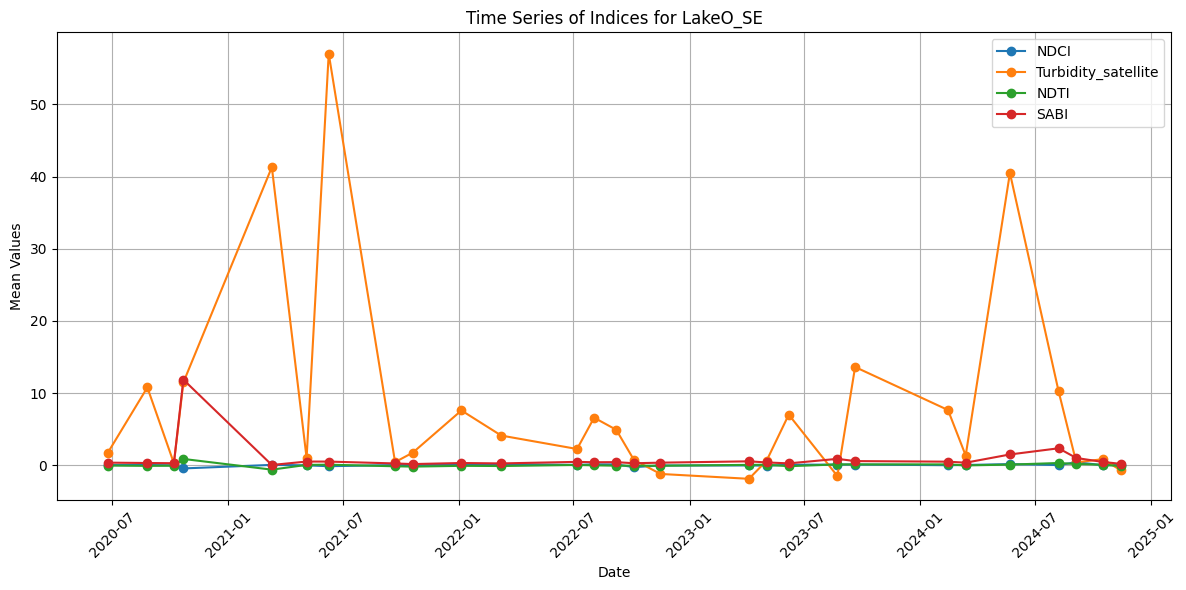

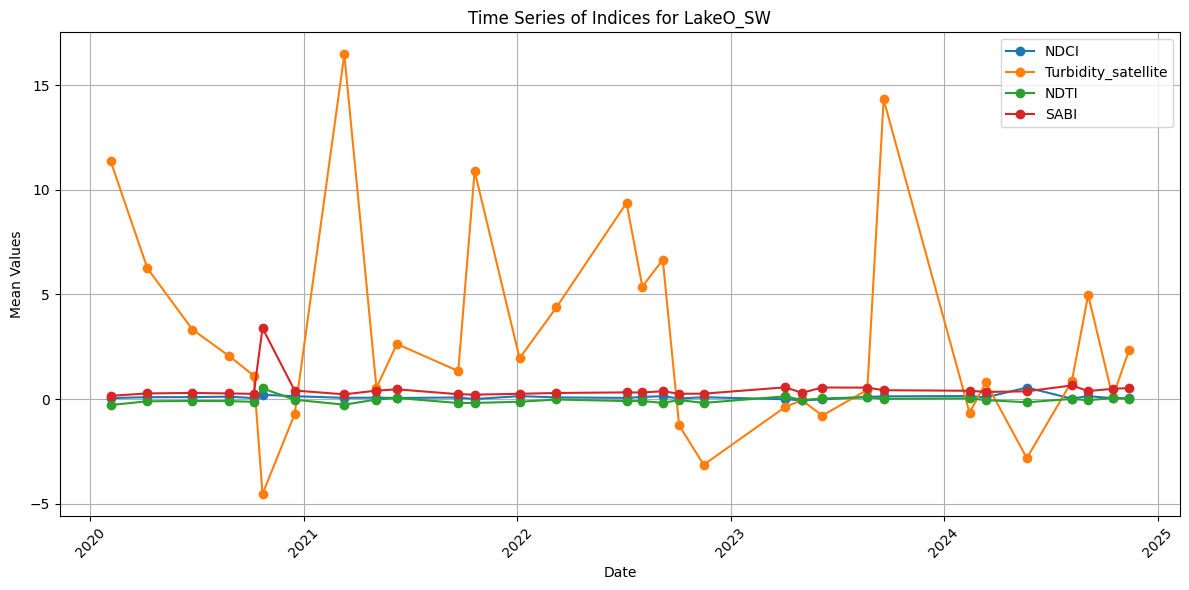

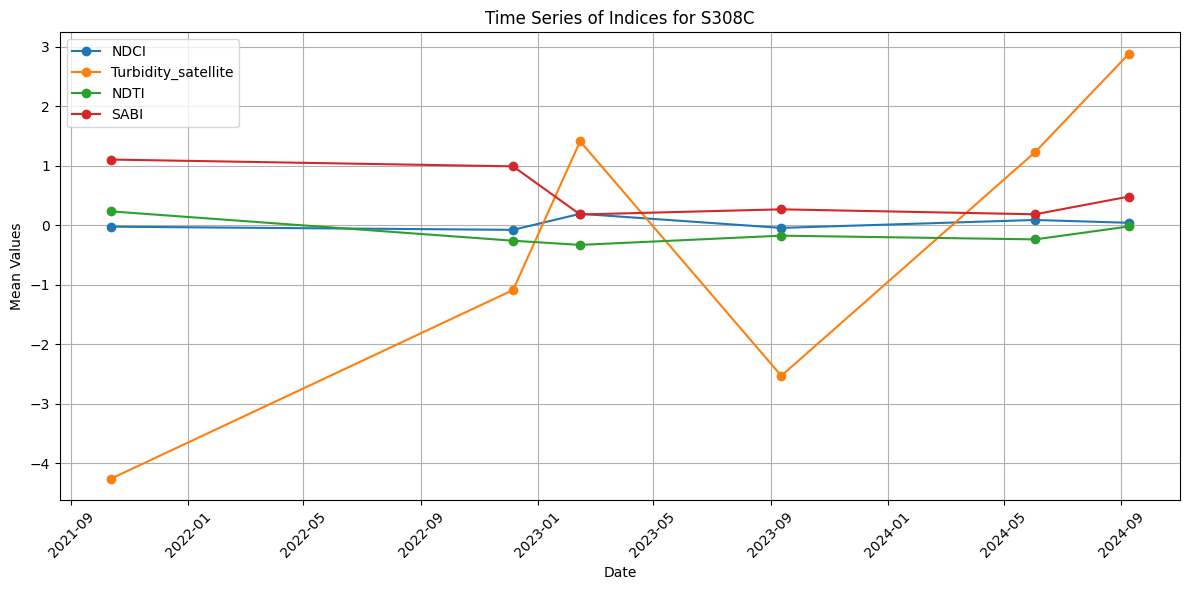

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data from the merged CSV file
# Make sure to replace 'Merged_Data_Final.csv' with the actual filename
data = pd.read_csv('Merged_Data_Final.csv')

# Preview the data
print(data.head())

# Convert Date column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Define the indices to analyze
indices = ['NDCI', 'Turbidity_satellite', 'NDTI', 'SABI']

# Group by both the unique shapefile identifier and date to calculate means
# Assuming there is a column 'shapefile_location' to identify each unique shapefile
grouped_data = data.groupby(['Shapefile', 'date'])[indices].mean().reset_index()

# Loop through each unique shapefile location and plot the time series
unique_shapefiles = grouped_data['Shapefile'].unique()

for shapefile in unique_shapefiles:
    shapefile_data = grouped_data[grouped_data['Shapefile'] == shapefile]
    
    plt.figure(figsize=(12, 6))
    for index in indices:
        plt.plot(shapefile_data['date'], shapefile_data[index], marker='o', label=index)
    
    plt.title(f'Time Series of Indices for {shapefile}')
    plt.xlabel('Date')
    plt.ylabel('Mean Values')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()